In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path ='/content/drive/My Drive/PlantDataset/PlantVillage'

In [ ]:
img_size = 64  # Resizing images to 64x64
batch_size = 32
epochs = 30
chanDim = -1  # For channels last
n_classes = 12

In [ ]:
# Preprocessing and Data Augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [ ]:
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
)

Found 14809 images belonging to 12 classes.


In [ ]:
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
)

Found 3695 images belonging to 12 classes.


In [ ]:
# Use EfficientNetB0 as base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define the CNN Model
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=(img_size, img_size, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,573,644 (13.63 MB)

 Trainable params: 3,570,764 (13.62 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
# Callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint("best_cnn_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)


In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[checkpoint, early_stop],
    verbose=1,
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4930 - loss: 1.8367
Epoch 1: val_accuracy improved from -inf to 0.31204, saving model to best_cnn_model.keras
463/463 ━━━━━━━━━━━━━━━━━━━━ 3668s 8s/step - accuracy: 0.4932 - loss: 1.8357 - val_accuracy: 0.3120 - val_loss: 4.9694
Epoch 2/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7114 - loss: 0.8926
Epoch 2: val_accuracy improved from 0.31204 to 0.74506, saving model to best_cnn_model.keras
463/463 ━━━━━━━━━━━━━━━━━━━━ 359s 771ms/step - accuracy: 0.7114 - loss: 0.8925 - val_accuracy: 0.7451 - val_loss: 0.7340
Epoch 3/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.7687 - loss: 0.6901
Epoch 3: val_accuracy improved from 0.74506 to 0.76725, saving model to best_cnn_model.keras
463/463 ━━━━━━━━━━━━━━━━━━━━ 359s 770ms/step - accuracy: 0.7687 - loss: 0.6901 - val_accuracy: 0.7673 - val_loss: 0.7216
Epoch 4/30
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.7937 - loss: 0.6162
Epoch 4: val_accuracy did

In [ ]:
model.load_weights("best_cnn_model.keras")


In [ ]:
val_loss, val_accuracy = model.evaluate(val_data, verbose=1)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 340ms/step - accuracy: 0.8875 - loss: 0.3375
Validation Accuracy: 88.44%


In [ ]:
# Generate predictions and classification report
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

116/116 ━━━━━━━━━━━━━━━━━━━━ 39s 331ms/step


In [ ]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.08      0.06      0.06       199
                     Pepper__bell___healthy       0.09      0.07      0.08       295
                      Tomato_Bacterial_spot       0.12      0.12      0.12       425
                        Tomato_Early_blight       0.04      0.04      0.04       200
                         Tomato_Late_blight       0.09      0.08      0.09       381
                           Tomato_Leaf_Mold       0.05      0.04      0.05       190
                  Tomato_Septoria_leaf_spot       0.12      0.12      0.12       355
Tomato_Spider_mites_Two_spotted_spider_mite       0.09      0.09      0.09       337
                        Tomato__Target_Spot       0.09      0.14      0.11       280
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.20      0.20      0.20       641
                Tomato__Tomato_mosaic_vi

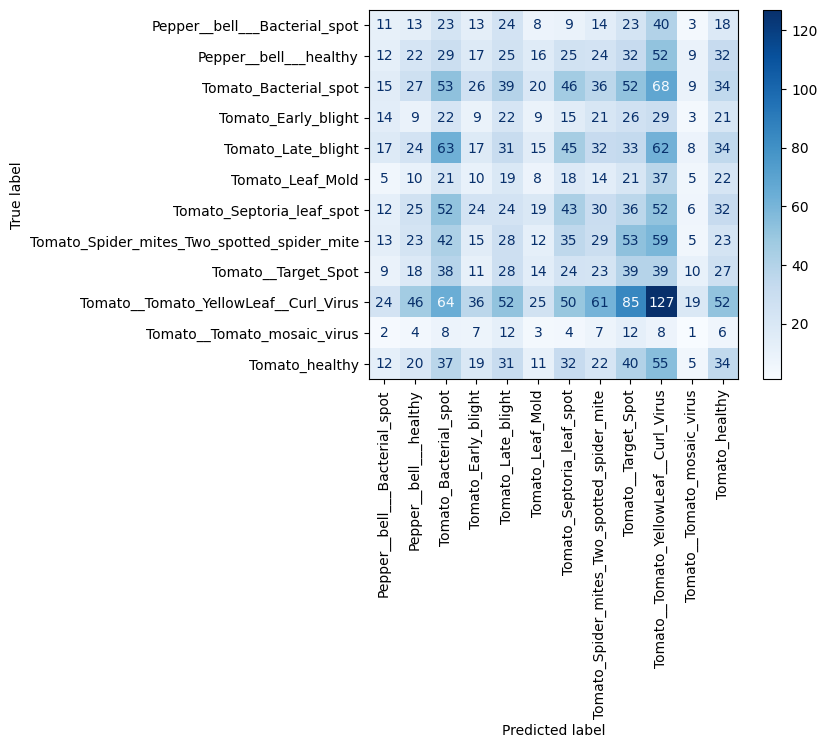

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show()

Text(0.5, 1.0, 'Model Accuracy')

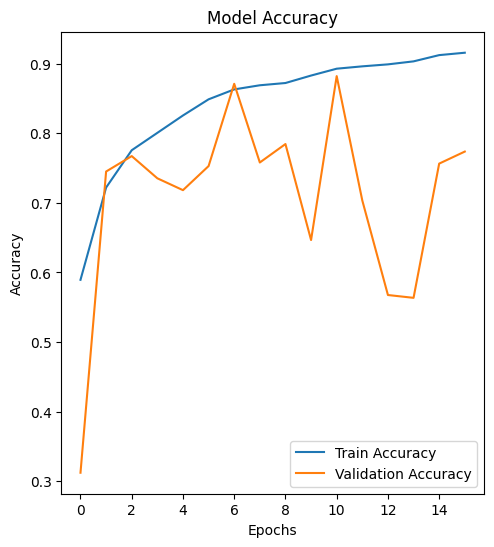

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

Text(0.5, 1.0, 'Model Loss')

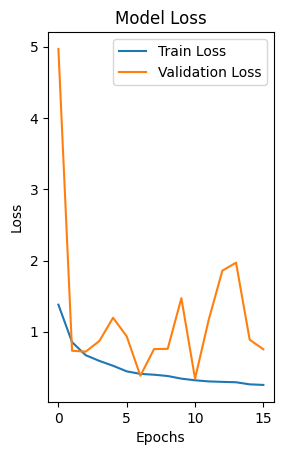

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Print final training and validation accuracy
train_accuracy = history.history["accuracy"][-1]
val_accuracy = history.history["val_accuracy"][-1]

print(f"Final Training Accuracy: {train_accuracy:.2f}")
print(f"Final Validation Accuracy: {val_accuracy:.2f}")


Final Training Accuracy: 0.92
Final Validation Accuracy: 0.77


In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_data, verbose=1)
print(f"Validation Accuracy: {val_accuracy:.2f}")


116/116 ━━━━━━━━━━━━━━━━━━━━ 43s 364ms/step - accuracy: 0.8782 - loss: 0.3585
Validation Accuracy: 0.88


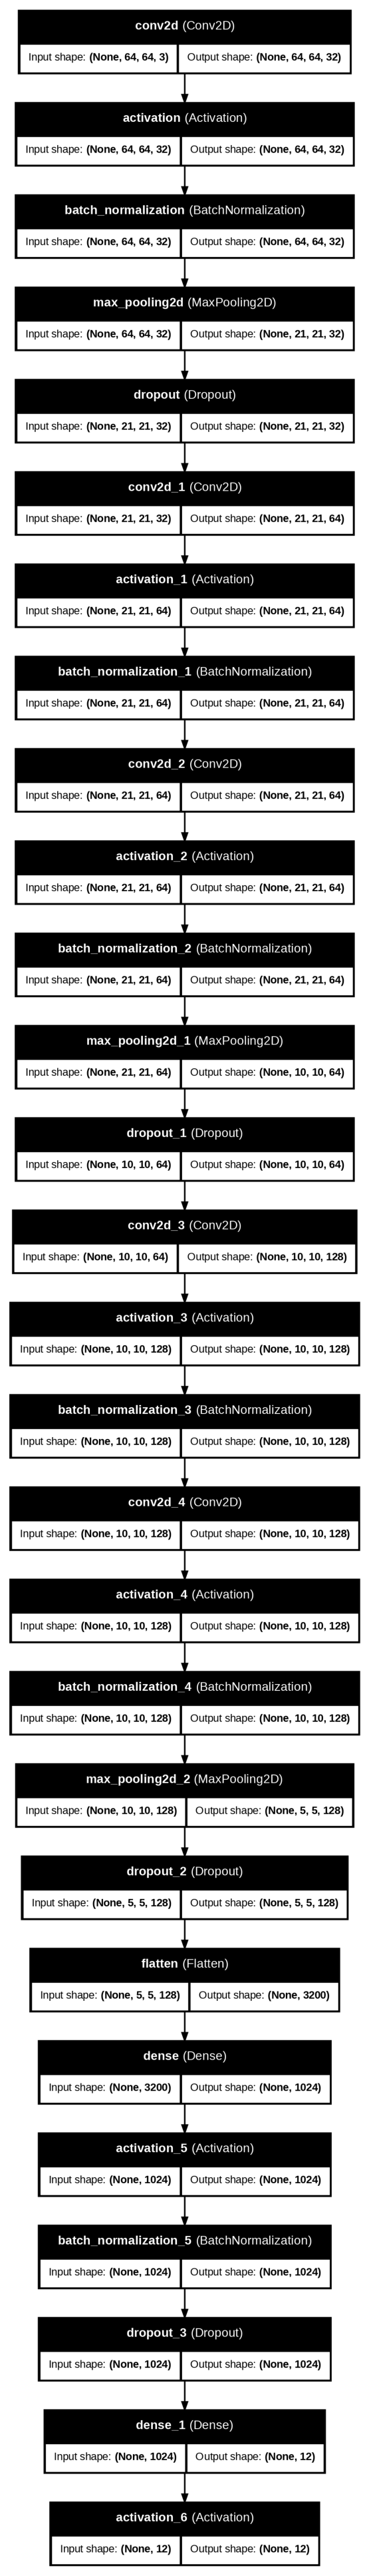

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Visualize the model architecture with improved clarity
plot_model(
    model,
    to_file="model_structure_clear.png",  # Save to a clear and distinct filename
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,  # Set to False for simplicity if nested models are not used
    dpi=150,  # Increased DPI for higher resolution
    rankdir="TB"  # Top-to-bottom layout for better vertical alignment
)

# Display the saved structure
img = plt.imread("model_structure_clear.png")
plt.figure(figsize=(50, 50))
plt.imshow(img)
plt.axis('off')
plt.show()
